In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
from keras.utils import np_utils
from glob import glob
from PIL import Image
from tensorflow.contrib.keras.api.keras.applications import vgg19
from tensorflow.contrib.keras.api.keras.preprocessing.image import load_img, img_to_array
from scipy.misc import imsave, imresize
import cv2

Using TensorFlow backend.


In [2]:
IMAGE_SIZE = [224, 224]

In [3]:
# Define the shape of the output image
BASE_HEIGHT = 224
img_h = BASE_HEIGHT
img_w = BASE_HEIGHT

In [4]:
def preprocess(img_path):
    # Preprocessing to make the style transfer
    # possible
    img = load_img(img_path)
    img = img_to_array(img)
    # This dimensions are for Tensorflow backend
    img = imresize(img, (img_h, img_w, 3))
    img = img.astype('float64')
    # Add the batch dimension
    img = vgg19.preprocess_input(img)
    return img

In [5]:
def load_image(filename, max_size=None):
    image = Image.open(filename)

    if max_size is not None:
        # Calculate the appropriate rescale-factor for
        # ensuring a max height and width, while keeping
        # the proportion between them.
        factor = max_size / np.max(image.size)
    
        # Scale the image's height and width.
        size = np.array(image.size) * factor

        # The size is now floating-point because it was scaled.
        # But PIL requires the size to be integers.
        size = size.astype(int)

        # Resize the image.
        image = image.resize(size, Image.LANCZOS)

    # Convert to numpy floating-point array.
    return np.array(image)

In [6]:
np.set_printoptions(threshold=np.nan)

In [7]:
train_path = '/home/phucnguyen/.kaggle/datasets/moltean/fruits/fruits-360/Training'
test_path = '/home/phucnguyen/.kaggle/datasets/moltean/fruits/fruits-360/Test'
folders_train = glob(train_path + '/*')
folders_test = glob(test_path + '/*')
img_files_train = glob(train_path + '/*/*.jp*g')
img_files_test = glob(test_path + '/*/*.jp*g')

In [8]:
def y2indicator(Y):
  K = len(set(Y))
  N = len(Y)
  I = np.zeros((N, K))
  I[np.arange(N), Y] = 1
  return I

In [9]:
# num_classes = len(folders_train)
num_classes = 40
print('Number of classes: ', num_classes)
print(len(folders_test))

Number of classes:  40
75


In [10]:
#Get train data from Training folder
X_train = []
Y_train = []
for i in range (0, num_classes):
  img_files = glob(folders_train[i] + '/*.jp*g')
  for img in img_files:
    X_train.append(preprocess(img))
    Y_train.append(i)
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)

/home/phucnguyen/miniconda2/envs/phucnguyen/lib/python3.5/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


In [11]:
#Get test data from Test folder
X_test = []
Y_test = []
for i in range(0, num_classes):
  img_files = glob(folders_test[i] + '/*.jp*g')
  for img in img_files:
    X_test.append(preprocess(img))
    Y_test.append(i)
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)

/home/phucnguyen/miniconda2/envs/phucnguyen/lib/python3.5/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image number:  16833
/home/phucnguyen/.kaggle/datasets/moltean/fruits/fruits-360/Training/Apple Red 2


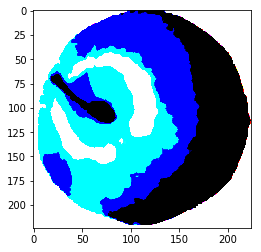

In [12]:
num_train = Y_train.shape[0]
i = np.random.randint(0, num_train)
print("Image number: ", i)
plt.imshow(X_train[i])
print(folders_train[Y_train[i]])

In [13]:
#normalize and shuffle data
Y_train = y2indicator(Y_train)

print("X_train shape: ", X_train.shape, "Y_train shape: ", Y_train.shape)

X_train shape:  (20218, 224, 224, 3) Y_train shape:  (20218, 40)


In [14]:
Y_test = y2indicator(Y_test)

print("X_test shape: ", X_test.shape, "Y_test shape: ", Y_test.shape)

X_test shape:  (6786, 224, 224, 3) Y_test shape:  (6786, 40)


In [15]:
resnet = ResNet50(include_top=True, weights='imagenet', input_shape=(BASE_HEIGHT,BASE_HEIGHT,3))

In [16]:
# print(resnet.summary())

In [17]:
last_layer = resnet.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
out = Dense(num_classes, activation='softmax', name='output_layer')(x)
model = Model(inputs=resnet.input, outputs = out)

In [18]:
#freeze parameters training
for layer in model.layers[:-1]:
  layer.trainable = False

In [19]:
model = Model(inputs=model.input, outputs=out)

In [20]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [21]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [22]:
res = model.fit(X_train,
         Y_train,
         batch_size=32,
         epochs=5, shuffle = True)

Epoch 1/5
20218/20218 [==============================] - 78s 4ms/step - loss: 0.1680 - acc: 0.9646
Epoch 2/5
20218/20218 [==============================] - 75s 4ms/step - loss: 0.0281 - acc: 0.9895
Epoch 3/5
20218/20218 [==============================] - 75s 4ms/step - loss: 0.0247 - acc: 0.9904
Epoch 4/5
20218/20218 [==============================] - 73s 4ms/step - loss: 0.0222 - acc: 0.9894
Epoch 5/5
20218/20218 [==============================] - 76s 4ms/step - loss: 0.0201 - acc: 0.9921


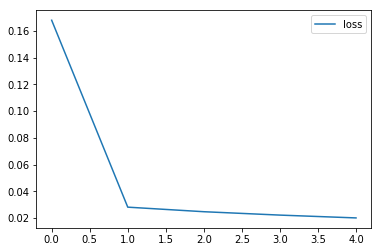

In [23]:
plt.plot(res.history['loss'], label='loss')
plt.legend()
plt.show()

In [24]:
score, acc = model.evaluate(X_test, Y_test,
                            batch_size=64)

6786/6786 [==============================] - 25s 4ms/step


In [25]:
print('Test score: ', score)
print('Test accuracy: ', acc)

Test score:  1.9963448136725683
Test accuracy:  0.5008841732979664
